## Thermal Beam Simulation for Er+Li Quantum Gas Platform

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from numba import jit
import random
import scipy
from tqdm import tqdm

from scipy.special import erf
from scipy.interpolate import interp1d as interp
from scipy.stats import kde


Relevant physical constants and properties of each element:

In [ ]:
## Key physical constants
hbar=1.0545718 * 10**-34; #[J/s]
g=9.81; #Acceleration due to gravity [m/s^2]
mu_b=9.274001 * 10**-24; #Bohr magneton [J/T]
k_b=1.38064852 * 10**-23; #Boltzmann constant [J/K]
amu = 1.66054*10**-27; #[kg conversion]

## Er constants
m_er=167.259 * amu; #[kg]
linewidth_er=2*np.pi*29.7*10**6; #[Hz]
lambda_er=401*10**-9; #[m]
k_er=2*np.pi/lambda_er;
Isat_er=602; #[W/m^2]
recoilvel_er=hbar*k_er/m_er;
capture_vel_er=15; #[m/s] actual is 5.6 !!!!


## Li constants
m_li=6.941 * amu; #[kg]
linewidth_li=2*np.pi*5.872*10**6; #[Hz]
lambda_li=671*10**-9; #[m]
k_li=2*np.pi/lambda_li;
Isat_li_d1=75.9; #[W/m^2]
Isat_li_d2=25.4; #[W/m^2]
recoilvel_li=hbar*k_li/m_li;
capture_vel_li=40; #[m/s] NEED TO CHANGE



#### Generating thermal Er/Li atoms from an oven 

In [ ]:
## Geometric factors
cruc_diam=0.012; #12mm in m
cruc_len=0.091; #91mm in m

hl_len=0.061; #61mm in m

#Apertures
ap_diam=0.003 #3mm in m
ap_spacing=0.05; #50mm in m

#Micronozzle array
num_holes=700;
hole_diam=200*10**-6; #200 micron in m
nozzle_len=0.01; #10mm in m
array_diam=0.006; #6mm in m

ap2_to_exit_len=0.011; #11mmm in m

oven_len_tot=cruc_len+hl_len+ap2_to_exit_len;

## Temperature/operating conditions (Er)
T_ovenc=1200; #[C]]
T_oven=T_ovenc+273.15; #[K]
T_hl=T_oven+100;

num_er_atoms=10000;

In [ ]:
###############################################################################

def generate_positions(n,cruc_diam,cruc_len):
    """ generate a set of position vectors in 3D from the oven geometry """
    pz=np.random.uniform(cruc_len,cruc_len,n);

    flag=0;
    while flag==0:
      px=np.random.uniform(-array_diam/2,array_diam/2,1);
      py=np.random.uniform(-array_diam/2,array_diam/2,1);
      if ((px**2 + py**2) < (array_diam/2)**2): flag=1

    return px, py, pz

###############################################################################

## Random velocity generation from a Maxwell-Boltzmann distribution. I follow:
# https://github.com/tpogden/quantum-python-lectures/blob/master/11_Monte-Carlo-Maxwell-Boltzmann-Distributions.ipynb

vmin=0;
vmax=1500; #[m/s]

###############################################################################

def MB_speed(v,m,T):
    """ Maxwell-Boltzmann speed distribution for speeds """
    kB = 1.38e-23
    return (m/(2*np.pi*kB*T))**1.5 * 4*np.pi * v**2 * np.exp(-m*v**2/(2*kB*T))

###############################################################################

def MB_CDF(v,m,T):
    """ Cumulative Distribution function of the Maxwell-Boltzmann speed distribution """
    kB = 1.38e-23
    a = np.sqrt(kB*T/m)
    return erf(v/(np.sqrt(2)*a)) - np.sqrt(2/np.pi)* v* np.exp(-v**2/(2*a**2))/a

###############################################################################

def generate_velocities(n,m,T):
    """ generate a set of velocity vectors in 3D from the MB inverse CDF function """
    # create CDF
    vs = np.arange(0,vmax,0.1)
    cdf = MB_CDF(vs,m,T) # essentially y = f(x)

    #create interpolation function to CDF to find speeds
    inv_cdf = interp(cdf,vs,fill_value="extrapolate")

    rand_nums = np.random.random(n)
    speeds = inv_cdf(rand_nums)
    
    # spherical polar coords - generate random angle for velocity vector, uniformly distributed over the surface of a sphere
    theta = np.arccos(np.random.uniform(0,1,n))   
    #phi = np.random.uniform(0,2*np.pi,n)
    phix=np.tan(2*np.random.standard_cauchy(n)*np.pi/180)
    phiy=np.tan(2*np.random.standard_cauchy(n)*np.pi/180)

    # Cauchy divergence, as informed by https://colab.research.google.com/drive/1CzNiRicL9-K4AuA_YXp0zJKUwdAa4cPs
    
    # convert to cartesian units
    vz = speeds * np.cos(theta)
    #vx = speeds * np.sin(theta) * np.cos(phi) 
    #vy = speeds * np.sin(theta) * np.sin(phi)
    vx = vz * phix
    vy = vz * phiy
    
    
    return speeds, vx, vy, vz

###############################################################################


Testing:

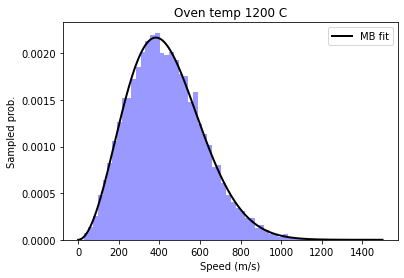

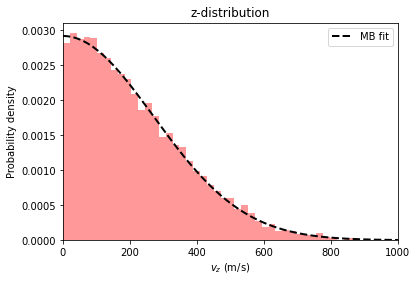

In [ ]:
#Testing velocity distribution

spd, vx, vy, vz = generate_velocities(num_er_atoms,m_er,T_oven)

fig = plt.figure()
ax = fig.add_subplot(111)

#generate histogram of velocities
ax.hist(spd,bins=50,fc='b',alpha=0.4,lw=0.2,density=1)
ax.set_title('Oven temp 1200 C')

#compare this histogram to f(v) - MB_speed
vs = np.arange(0,vmax)
mass = m_er
T = T_oven
fv = MB_speed(vs,mass,T)
ax.plot(vs,fv,'k',lw=2,label='MB fit')

ax.set_xlabel('Speed (m/s)')
ax.set_ylabel('Sampled prob.')
ax.legend(loc=0)

#check z-direction
fig = plt.figure()
ax = fig.add_subplot(111)

h,b,c = plt.hist(vz,bins=50,fc='r',alpha=0.4,lw=0.2,density=1)

ax.set_xlabel('$v_z$ (m/s)')
ax.set_ylabel('Probability density')
ax.set_title('z-distribution')
plt.draw()

u = np.sqrt(2*k_b*T/mass)
vzt = np.arange(0,4*u,u/50)
mbz = np.exp(-vzt**2/u**2)/np.sqrt(u*np.pi)
mbz /= (mbz.sum() * (vzt[1]-vzt[0]))
ax.plot(vzt,mbz,'k--',lw=2,label='MB fit')
ax.legend(loc=0)
ax.set_xlim(0,1000);

In [ ]:
# Comparing to micronozzle result

num=10000

t,u,v,w=generate_velocities(num,m_er,T_oven)

thetax=np.arctan(u/w)*180/np.pi;
thetay=np.arctan(v/w)*180/np.pi;

lim=5
bins=100

s=2*np.random.standard_cauchy(num)

plt.xlabel('Divergence angle (magnitude) in degrees')
plt.ylabel('Atom fraction')
plt.title('Micronozzle simulation coarse grain')
plt.xlim([0,lim])
plt.hist(abs(s),bins,range=[0,lim],density=1,fc='r',alpha=0.4,label='Micronozzle result');
plt.hist(abs(thetax),bins,range=[0,lim],density=1,fc='g',alpha=0.4,label='x-divergence');
plt.hist(abs(thetay),bins,range=[0,lim],density=1,fc='b',alpha=0.4,label='y-divergence');
plt.legend();


In [ ]:
#micronozzle final data, sample this directly
# BRING IN NEW DATA AND DO A BETTER JOB SAMPLING FROM IT

vz_mnf=[318.09722909892366, 226.0620928923318, 211.16867135462235, 96.83778963431865, 418.7708697728221, 205.37708136925124, 168.76773728524697, 280.6354738593697, 293.5464645387187, 335.9228870208897, 376.9752858207021, 211.89544545385797, 530.9665909725147, 174.12095466851073, 158.487046375555, 738.4942231764003, 394.7231337619872, 391.0809638768553, 541.3761949152329, 376.92804788491685, 222.40494904068873, 699.02890412199, 491.6643063096471, 496.46528813007683, 720.1141680734935, 130.5542915580604, 406.89393063231273, 460.7313671828317, 571.3089745590372, 481.80229783589823, 280.80253276774323, 353.18025734532023, 829.3363369243912, 426.4122276248505, 390.71951762892354, 471.45666086378935, 246.40836714107107, 511.25214448055624, 574.9650743014367, 577.6805265811369, 386.7207375440884, 341.53009387249966, 108.58064136698431, 123.4785479004019, 358.4426671726648, 848.9647978643378, 271.23343593338234, 591.3415905417496, 467.97515718122185, 629.2058097323583, 604.7818839061136, 256.32525811614124, 439.03252575083764, 306.4407961828053, 201.24415681110895, 336.1427235448744, 465.02326801756146, 420.8908327973937, 658.1102965780294, 475.1908580652442, 398.9881169341736, 362.71800452070124, 477.30573922433183, 889.8988144018239, 934.9140436126779, 734.4936035630357, 270.789649814418, 281.12827259174634, 329.1816781103574, 688.5007345081018, 443.84821862308854, 405.4860606589328, 229.40117391789806, 561.6375491346304, 821.452574809034, 424.2687551142543, 192.46969049091513, 421.94604703282846, 567.5475061028834, 305.5577273286536, 327.4334227226783, 277.8399884606486, 150.02468643776635, 283.03965061982075, 323.4014947367525, 367.42505772624503, 440.0464073267552, 450.1345702290216, 279.1640291571751, 442.97483665911574, 189.83881699963234, 414.76277787277917, 115.21175545536889, 322.9889388306484, 294.5381002983361, 419.2702428157391, 268.1754833200323, 491.43732931689055, 395.3208691370724, 281.5028522229479, 472.72563444278325, 208.88124177553811, 359.3685313357797, 102.6922402669328, 455.8596062159692, 296.7614131654806, 412.3681086320996, 194.6626745213953, 198.25541389129063, 408.0935574329869, 288.51141412045143, 302.8438286811763, 745.9406242277256, 564.4732471443704, 445.13122918199423, 720.9832816879036, 636.6962541637378, 438.53497054546773, 130.09275827424727, 706.3538290108529, 245.08120720356797, 446.98134411824685, 560.692134526919, 535.6697700548141, 600.1286527584915, 128.705103810689, 262.54376310486106, 366.8276261359349, 422.9479612094522, 312.65633916588433, 192.6945953634185, 180.39475203901478, 288.87570320546007, 269.5525404272647, 527.3702535224522, 204.12348206155784, 48.49361634473581, 260.4283803053775, 359.74024373275347, 611.4800547296628, 69.89451861727503, 397.5425852953407, 640.0181141730243, 315.1053722949548, 575.325926802095, 424.3083738392217, 598.9548448465109, 358.07895396033905, 153.6906855670317, 556.6177096599789, 597.0419742346022, 191.59758880837873, 341.5639611425991, 222.27894297399686, 481.11310801957075, 131.5644165139629, 382.65699012218766, 71.58189789524539, 612.4547316244123, 234.3227835377437, 617.0943253613892, 502.08353305492005, 294.6389869862287, 281.3596703815646, 450.98719420044733, 537.7031957326528, 397.3312086152925, 292.8526790929586, 376.18481441015206, 217.54351407776707, 153.40174469580248, 694.3230113493071, 127.06626113800911, 132.90712855273944, 178.94423001707514, 548.1639260146443, 810.7938397200476, 168.57621809585055, 514.3973180188333, 682.0333743051688, 183.85500162587664, 165.1590707113515, 622.8877695024781, 494.63333361143833, 597.1918468766768, 426.6095815497195, 110.34964100820055, 399.1947632592252, 554.630959950786, 331.06849149644455, 133.04867756136485, 340.733468051635, 389.90162742891243, 463.93532947275327, 360.87516888660963, 288.1203401416954, 579.8732649192617, 626.2307940402278, 358.57791799709383, 188.9047529096688, 463.7819861763592, 155.5186941726294, 154.56071635056023, 552.3119847444801, 276.64120434700567, 397.6740305944304, 359.06212551839457, 415.132309500299, 538.4970337418692, 603.5616369470808, 453.86807077940625, 313.5981172519564, 643.5712839314433, 425.1392583393132, 331.52516530632334, 649.3905514437515, 221.5915202857799, 293.1231161129588, 101.30341152048139, 415.13446270846634, 326.22853139707695, 224.98859490738266, 593.6365756603612, 456.8397169169014, 227.95319448709606, 186.25462026855556, 496.7999080174312, 282.7043762282377, 189.3097871380478, 218.14728351499113, 93.72590088763121, 460.1181608776539, 385.3228256883723, 176.2651927195158, 376.2856783107171, 215.06843383978236, 131.80725072503563, 223.08729996645127, 420.15695159158815, 455.73976559243334, 623.624353227048, 141.64939635130656, 280.5027793928439, 73.94658507742236, 270.4392615821005, 396.9181510549147, 199.98854862424142, 167.32582930334416, 417.4874361356773, 412.1284321312313, 260.7722201508622, 975.8316888847096, 166.53064585647746, 175.41026728351562, 509.8812058124125, 324.30749841161344, 485.8755476705445, 561.2682196232122, 586.6540914861718, 526.7038614142905, 523.2230936430549, 296.707977368027, 601.723177173774, 120.96392137950218, 234.89861243619626, 293.9926303513474, 534.0553553279115, 594.9175033992393, 186.52856396961238, 582.4512726848585, 572.8966228357724, 70.49836596439985, 525.2483235712591, 863.3661295193162, 408.8925363854301, 548.0054558471004, 273.4301647322468, 530.9928181873591, 505.3709723895627, 538.3332669917085, 403.5441540234386, 515.3859834877705, 843.5194519124112, 508.7054912866762, 252.61063586745624, 248.64789739675874, 247.04156166566182, 283.8082196060521, 269.63312876882026, 681.553559769843, 297.97324133107315, 308.4375032880171, 517.1331575876126, 316.08177895880993, 663.4370340041773, 567.1255573491685, 361.72605165363245, 387.61955996335917, 376.89803852880567, 45.733605943953926, 333.091384599471, 179.48603420192555, 568.9017249094209, 519.0547419514635, 528.0100554283517, 439.8079639783559, 258.9721738721629, 43.23600104327863, 317.7659471248484, 403.789663719345, 716.9063497292072, 427.5913119966557, 385.48007023908593, 537.1255305114397, 542.4573203682836, 417.23465141196846, 396.169291760895, 408.4406457355305, 608.6046753783769, 293.2407754674404, 359.0849975143584, 415.2091133136082, 228.84780850884744, 390.57601367020743, 599.9354742991513, 694.2985036062499, 315.33213841472565, 388.08874615325897, 471.99665557939863, 519.3384323698424, 366.072936269779, 102.3287937995665, 523.6948875525504, 503.0782409404244, 259.02565416180414, 566.7766555389475, 158.66583141788126, 583.8649980854926, 607.6280246042343, 263.18383442025527, 289.11562777178546, 519.3908308026573, 377.742101667633, 150.70824962992725, 272.79144389213974, 253.98715131075278, 714.4883729798269, 603.5803717524547, 653.1359091066502, 168.1639550943359, 339.5409396006466, 128.43440316823163, 420.105483456279, 430.6255118602387, 413.51619001206427, 611.25464792533, 929.8997740714299, 555.1733103098533, 111.23680351832199, 386.2649676500407, 775.4231540479939, 436.755455870963, 462.5174779282481, 162.20551038448326, 605.7403210968371, 232.6941057340104, 474.40601216863774, 101.29144566162208, 525.3512093406076, 448.122434063003, 304.5933903572662, 620.9158088799072, 224.51832260017568, 617.3907207696061, 238.25999209692304, 420.86827393983395, 416.31598206304244, 345.66095434562794, 576.6694968628583, 236.64432714787242, 564.5875157528346, 309.0290204010859, 545.3787659120968, 534.5266298473206, 139.2874734301719, 305.92654688688106, 465.6001578728919, 117.86583063722045, 106.52391851939669, 875.57286737594, 228.0578728086624, 318.8738522674761, 439.1000805181733, 344.2056774188851, 410.7457429736172, 189.7358132413318, 321.18314505225067, 742.9672381625841, 260.7906545160077, 373.4939790500658, 135.43690183248634, 403.1414735233829, 366.8788725874617, 632.2533626784699, 199.44211199218742, 620.3879425042968, 386.4161199490512, 330.2733167093175, 458.11772969583944, 608.4881541412734, 280.31076527990086, 730.327857439983, 467.2862436994052, 334.4919776993027, 46.695018171560854, 135.89114702949877, 123.79297205378225, 901.6794726424138, 176.4597735015583, 528.7381257823575, 465.0239393833022, 580.2432657270318, 497.21647932265967, 31.852195922499327, 353.1540430645741, 475.34455781261806, 161.30032692851515, 359.44687930278275, 367.66243856345415, 262.69711511650587, 348.4359447775143, 269.96142553359357, 184.25070068273098, 438.1154808802412, 462.15928495296765, 667.4357251462703, 421.103073300344, 112.00166354086161, 591.403472097185, 65.86166376165714, 354.214993697477, 464.276930803309, 577.5811916242102, 723.6961132583986, 689.6078296320107, 446.09108271198573, 281.6404362782077, 228.72229687997958, 259.1499072418513, 586.0038384125633, 367.2274667132491, 454.4925973348768, 402.4530058932552, 163.17410644894892, 355.91079206032106, 519.6493445824846, 285.0721207009466, 423.7907907794769, 122.71153565501791, 636.9690069008005, 263.75302157599646, 535.1618412030579, 40.50205061612022, 536.275035573075, 756.4214385691325, 92.70484992163207, 201.33291822599375, 404.3150530763651, 469.9818505760067, 143.3166021830301, 1009.4332389132265, 395.6239838925901, 383.7678732437899, 263.03189472332014, 265.31553719288945, 348.9757746666378, 348.8509159321751, 88.03433353132829, 560.4601402836585, 1094.2954202647347, 443.6298806365091, 522.2607012828062, 255.41260767480978, 546.958345615245, 512.7290278184038, 216.70306245280545, 233.42200639042687, 151.03952213935122, 419.67493823180655, 598.8201149942363, 462.4625249277647, 584.1350855517735, 172.3612712972722, 526.498291728017, 781.8108692242421, 361.79224734145254, 519.8542838980024, 222.06914798705844, 191.96687371658695, 367.47767377665053, 411.94373158470745, 141.73983349519136, 766.5767218362207, 637.0864130966769, 322.16026563114394, 403.0948907718379, 195.76143125976665, 239.92150771645626, 426.87879159286626, 415.81931593814846, 255.0583453053701, 212.61229821156746, 528.9640259142914, 937.5233169656161, 714.9595185329538, 108.53488208173445, 344.80319943686055, 360.000041596531, 500.9115024157129, 289.8747904628296, 579.0197241256623, 223.49534885279797, 335.1992603900511, 117.28453805370798, 123.39342150835542, 447.07527717402496, 324.40851260862047, 591.1187253709871, 88.93225400541382, 463.96192832087735, 546.1757360825104, 280.41367068631916, 555.6246586435609, 316.3995761501503, 347.97870687719444, 546.4157972756567, 161.96464804052457, 389.79698667451765, 27.55760707129351, 138.97721734545954, 399.87033620403344, 379.24718146453705, 422.73697284378466, 614.1316519769902, 600.5275262621624, 472.22762944443275, 223.1715292705383, 88.62687345123632, 454.67029863299757, 412.27357021333955, 467.5084290250986, 589.6746303191147, 190.02691926950365, 312.1741491002306, 584.8005242004017, 115.40791713948728, 406.23068750522685, 254.9892353514993, 504.696943681715, 354.9797068791438, 708.0551334553986, 241.61310067938314, 77.36569235250457, 678.2959480755579, 742.786970903131, 37.33161840768773, 631.1951610410426, 338.6877054090132, 448.98008984273207, 272.9821762803564, 287.61100638596827, 110.3565593491007, 102.10224324347372, 482.6742620034352, 107.11092593429505, 493.8387640623931, 356.135989504347, 86.78671206685529, 392.3204018596582, 234.97758075419205, 541.1587432474496, 612.6242824699979, 629.4969027986763, 473.28068673857524, 456.03014747763734, 535.814080229735, 327.9008771728264, 339.839134444464, 98.22793800573493, 601.5059198644091, 116.55317685987931, 385.33842244836694, 212.65340426068758, 351.2053131787818, 524.4112080693419, 493.1942328562089, 357.91105454374696, 179.86645610423847, 236.52136528495848, 221.99784843746073, 287.3932852531791, 107.31315192025193, 620.0912365944555, 505.3519699649289, 169.3721518314373, 425.26753261939996, 506.34779455438485, 241.66607894005043, 400.2773961453432, 611.2011069203671, 306.4618947223874, 667.1329222246447, 445.12527531959114, 280.16617129034137, 657.7089960713156, 160.83936976718505, 492.9381201695948, 409.4634498963412, 846.8343160317194, 456.59421783750264, 128.72121786522416, 440.8903528929642, 364.9524267929083, 294.9770301352572, 108.44761247352785, 243.3721419670132, 347.9056263355762, 320.21649173930024, 102.37830541659498, 247.58072789121678, 302.9141227989252, 201.6669194276899, 636.9913673059946, 350.5223286487391, 692.2964053829306, 592.5824949765124, 390.1153946689329, 270.02206245962947, 715.3037243634585, 235.62693328427198, 224.16514421086387, 518.6890002506494, 385.6921094863575, 447.07122522080755, 288.01550627788333, 698.7640494282576, 258.8137620468389, 655.6081028896709, 663.8139901093964, 374.3309148346308, 114.01406443956041, 397.2316447303781, 701.7179625978808, 652.5561213749364, 523.0704260422714, 190.47366699165292, 336.02752320949224, 346.75817046914136, 597.194908399934, 742.3220582669643, 353.5620782812998, 405.91700736780643, 567.1025248843442, 466.25838828751046, 305.1257991409928, 505.0546122709054, 248.47151387785703, 346.6081432562662, 194.97964595660557, 633.53353974005, 355.56616145848704, 182.24204867411942, 429.7082205895197, 458.9073739347249, 475.30506175341714, 601.4796129355515, 624.8191601054831, 122.80300144829059, 274.69526968360026, 351.421755112602, 183.31872503329905, 577.0154126727434, 241.09082602530307, 510.5186988707544, 480.90803367317744, 321.01715581600575, 147.42990761540398, 151.5435481963534, 500.0515144737427, 700.5159856077192, 292.1400668320917, 99.1175934800248, 521.9743378775954, 555.7395085648009, 573.7732420019181, 703.4726953875081, 407.9990810479384, 461.86299672290596, 495.1633657268584, 167.94181129098362, 248.2249121665836, 455.2868000384791, 394.73004982693016, 425.86034985914176, 946.5670266217696, 325.4658290929857, 425.91332836960925, 632.0198007447875, 599.7372890254038, 221.07232400259136, 89.5111641058266, 639.8985817890334, 303.1315215090702, 120.6099650707948, 276.2408547324346, 213.53301977999894, 264.8696767332259, 327.77310920995006, 286.653111955526, 613.9053771447856, 199.6325613845551, 721.1298302112201, 392.84968327002457, 258.6920279795679, 155.83982813927034, 546.3457943971628, 310.7988405803841, 130.35122438387336, 469.4896495460732, 257.19617724462296, 419.16582105283595, 491.84836671545276, 500.739046102594, 741.1272579527229, 600.7356811721376, 436.21050971331954, 560.9572116677119, 582.4379919056045, 332.69158963844524, 508.79682184090666, 583.3475335975669, 315.3713426101712, 846.7372170917198, 699.5056436170933, 573.8383435788253, 162.08002912021513, 537.3236465905374, 445.40305756124445, 593.8019043971732, 322.0161428063584, 623.3339836930751, 182.99632063845107, 227.06108460113228, 568.7737913429025, 611.5949365143036, 271.8963007519726, 158.9405425189705, 336.41382805871257, 597.4128158142688, 324.5918240718515, 513.0383086693336, 397.7181461251034, 730.4038526223521, 241.81174451687326, 215.54541940194127, 409.92834934860946, 485.6950728410192, 298.1777797866902, 609.6254795140421, 841.2289311393595, 755.731962620576, 436.88870093872015, 395.76950496000853, 455.2703981031136, 291.9703056269984, 257.12914865361205, 620.2151853762495, 310.96007534203716, 501.5940000990815, 667.7809391286704, 242.98040290915424, 270.8857724242897]
vy_mnf=[-28.99192229821254, 262.76239374666346, -71.3590481855311, -39.93720629940148, -115.7653702869724, -106.62816690004944, 138.67545022375194, 207.68800682794807, 171.5185675718405, 221.74013875736736, -10.149303217787345, 74.33406482365503, 65.21948104742502, 191.7725066669508, 185.4754092670604, 315.1854801427189, -99.67313453393932, 85.07554870469929, -224.8741913229036, 185.33219806819278, -92.98777549262421, 65.04781383323555, 83.4547700885634, 114.09679619297457, -10.268951161954663, 93.24109440328552, -431.71057350797554, 174.3967429311804, -24.300611449983414, -16.973192462686836, -154.0477075642841, -41.03734306499596, 36.86887540047239, 55.99308361750859, -294.654426870951, 148.5860098135363, -236.66151098252277, 130.72314021100178, -216.13044669569447, 400.52271015555107, 1.9183199137223892, -156.09858788478027, 85.83767208261489, -198.41701158159788, 155.57453984999577, -132.78802518874085, 196.3649894310359, -93.01712534828637, 254.65060778833478, 67.71306876318661, 65.98311406459668, 313.2966327567101, 5.051134853266415, 54.63314027944529, 61.34671028478855, -591.6226873136937, 95.87752597081146, -51.584640731921, -6.019037664399036, 270.1714887307365, 103.40316611040946, -780.2846850851058, -131.36955052722635, 345.1920743228207, -95.69078035216813, 125.87793235259264, 28.921442180864734, 24.62808749124912, -216.9878626645397, -9.646882246461496, 28.911242348241256, -1.1035708977777479, -33.835289471085844, -33.188548802850356, 360.26148244857126, -99.364600125414, -228.97219591460487, -290.5288729444745, -10.529849613560502, -727.5117952739753, -196.2440123150428, 146.46376214329325, -97.6968050360981, 112.74081317732416, 80.54701808421667, 104.86515449048551, 91.20692597073925, 489.125692193634, -129.72817351462103, -175.4866503476688, -209.9380034628097, 295.512239182694, 120.6885929276244, -48.487979917301274, 100.89603371798289, -111.27338943339205, 321.5183449359425, -107.70867759301271, -541.7485634466417, -1.989049498986816, 129.09873561655056, 2.2198047892017794, -611.7942273003258, 226.3311226276699, 201.88782714417997, -16.4948355165645, 94.14074426120555, 277.2390884115284, 3.7109039896943834, -169.34361103638443, -187.75350045280476, 56.1192419973669, -303.20500354224544, -319.5659383364857, 138.60286048657937, -34.53896557387842, 28.23736949255848, -469.058564628636, -322.0271489647996, 345.3550469127253, -122.62503668622297, 16.397221548549062, -10.68797952669554, -114.26940487683102, 7.863772227274018, 12.039222652116509, 149.45253369873407, 164.8567723092206, 92.93742084183661, 9.583259025691595, -119.86816249754274, 331.32517293101535, 59.90223705260034, -267.86040973616423, 48.71577412681513, -30.77555518239683, -5.601212946869492, 40.24344291597877, 24.969010947815256, -198.55578205099732, -269.7488211951624, 216.583389478801, -416.7750745883228, 12.212931273171586, 175.50325413003694, -10.583429995269091, 155.05689880278197, 176.26406501221325, 522.002890928578, 241.33546857761297, -36.811293657591065, -76.13687328094244, -94.73529973712995, -19.583795823560365, 82.32364621599135, 1.4995031523908662, 105.21653095137205, 34.48155434666099, -38.40917205772884, 24.633356534534567, 7.255385812685088, 354.12151362548656, -34.05322398163883, 118.94956021866413, 61.857541468158736, -41.20853477359134, -211.76322780112454, -146.99175419951098, -50.86094302252271, 524.7517400113964, -132.9053608919604, -23.25132974080168, -95.47839565130465, 401.35300569295316, 87.87030987783638, 114.01963829137888, -21.235984208660625, 427.3498031138849, -79.38706297547226, 10.342123242233791, -39.3815901938684, -194.60543510593092, 88.87709807415926, 110.30254671174754, -105.04477529807953, 67.73791793072363, 383.5993763960221, -127.4496745165294, -3.1966760523225366, 9.026674928575353, -405.67987299035093, 248.0944644286313, -26.728243760572227, -407.8791629379911, 258.15398987287864, 309.4632758278426, 45.03089627799859, 19.40322967447787, -179.4493396953885, -219.5445858392932, 84.59924758712039, -79.62720656993528, -33.88360824937205, 42.41269561261213, 51.59320622366136, 36.67039894623362, 141.65117572005963, -33.42578708923917, 13.05736952045153, 202.74897317399018, 53.572535789578495, -346.24341010763493, 142.29380321196996, 62.50232022816503, 136.6681955522475, -591.9452928488614, -37.5656511994232, -69.68287947814564, 66.95725109323418, 31.76540444891447, 97.64902803439642, 4.205100305319136, 70.73370990768072, -59.6755833312014, -269.67755358214913, -9.947276780249982, 235.32783366268274, -100.83225833272796, -90.7557349733067, 50.5921207101306, 191.67722845503562, -57.20383349194476, 57.56114340174038, -38.08888007870038, -5.525066339227662, 334.8959860672955, -4.912185351188536, -5.360730420412565, 109.09022021268407, -173.50598314325563, 44.557619677308786, -22.027235236168636, 67.41721874032116, 109.34675076946371, -34.46448050453449, 40.247137826025096, -281.128749561447, -104.21497857737717, -126.24098337066063, 248.1092706201147, 2.2106508165372665, -154.8028252085871, -106.27469225325294, 101.39145381632018, -269.01103736352155, -21.836556922697966, -48.894525153057174, -523.6841433460277, -0.9521334381324245, -127.11103673578938, -4.9332392992835565, 36.191952518358114, 9.717657410094477, 80.35742990052282, -35.96764598716396, -178.14087672194702, 68.35153185086969, -90.7931201288249, -12.071814206327794, -58.185918879729776, 15.424687745601782, -141.5279229486808, -26.283112787854787, -19.77225612019096, -39.738215197051254, 46.600397668179575, 29.822978958360434, 313.24143717379684, -332.3518415605754, 154.35900212353286, -474.1426925270473, 277.18765244081135, 58.59540059302386, -367.0292872053971, 531.5362578489028, -173.37012690819398, -87.55954140264674, -187.52278346757453, -3.433345041213218, -70.35327374772977, 58.49456609450382, 122.90807790429035, 82.37127398713021, -71.15813651899575, 6.949689537920161, -107.34551249248162, -29.09182507067363, -4.618183944838489, -306.78956294859836, 195.3007145327366, -64.31153455206652, 269.0723702914073, 101.37237064307327, -84.93008045809287, -0.0188859067612652, 76.41052515044468, 36.37386678782709, 349.62000852191943, -117.63213162590581, -391.530486192602, -101.29144293366099, 139.51939722766727, 53.128689525691264, -75.40511057474008, 384.76264920352975, 27.690913350313487, 130.32592327305755, -184.76808814416393, -54.6234581250615, 394.69940340706654, 97.34486243473395, 202.32255750504777, -416.77656488524946, 430.63679756947647, 109.46456155934165, 51.22662157533647, -33.98069817797103, -2.5139239916919642, -3.3614402035654503, -35.928972355321434, -236.2931234371193, 11.578737069102086, -155.59465970792394, 15.712752508834082, -90.92935196225622, -196.7542038152281, 60.71234569899816, 85.68423317579804, 102.14420949230912, -444.118896936619, -43.55429232002312, -204.0877822829211, -53.6673505075586, -169.57869027577067, -16.18281074129788, -372.13596377051823, -173.53856885359008, -34.63075528957211, -302.03067168338515, -124.35947917353428, 287.7840419552398, 91.98661924693634, 2.7524618639537293, -79.6738175232051, -10.065462202005909, 101.23119828267762, 173.15576201495324, -41.123718150411214, 136.0263494830068, 31.797890377270196, -10.44107524857872, 78.65750714631213, -77.37690383541849, 48.25964657420318, 62.330481325248954, 191.6294185086041, -292.8104869751036, 3.9842760458062845, 24.771747091903354, -68.15954869157345, 607.3359641310975, -193.15226182088466, -103.58682148126856, -5.9304815581338834, 2.1545537406595336, 32.80737148701057, -94.6116231444541, 19.593886703243857, -158.14702993628867, -122.91762703145861, -59.95303871181214, -52.788346373592795, -231.19960650933197, -21.252273707896876, -128.91375140907388, 1.7488014677669743, 82.10896443452486, 244.7674672897992, -149.05953809088956, 1.6790385599411919, 194.48068870402906, -362.2020077025112, -110.29583579509443, -241.29565008752795, 34.94998994873306, -14.936615056891817, -94.4315154779345, 178.26910704500827, -7.065314310880221, 524.8073220588244, -271.21028729000693, -33.02693367618695, 466.28453870809807, 205.668401069602, 197.06868364889522, 31.675310471117673, -205.6155956023549, -180.51989101566974, 87.68583545663758, 325.4559850240663, 425.44875357355005, 19.98672599628083, 150.11153506284612, -353.8632732356939, -12.015396444535172, -69.26629876591838, -102.62551479467159, -35.24557195936934, -31.257293305612034, 54.22050603865001, -87.69334096446306, -107.94541225651487, -9.054012690078682, -10.766695106431342, -59.93878322580609, 55.45871451222845, -3.903489719035607, 11.209306857501087, 21.588920319417365, 199.87806770403913, -84.91234170673422, -178.07825039583852, -24.81898895629513, -144.07023211286761, -306.90435417557796, -31.325740381554258, -100.23168710130999, 81.28895784601485, 301.8845577069983, -125.18401966876876, -1.9191468179989135, 60.19005833178027, 84.035663839091, 0.40061217667172355, -264.34428470646645, 135.03744572112294, 300.18559551154146, -87.85687553327075, 57.641653427740934, -37.63395704922331, 405.11081796155804, -225.69410633118716, 229.45841002763, -475.9552543231234, -149.38527497085005, 49.2153237908197, -25.460974906806477, 299.69546204650436, 233.98532174919578, -17.776218561374456, 35.681426225893205, 351.76469590609497, -96.39810170865596, -10.902832969580272, -20.72214052466822, -87.59501344841186, -158.34613895137142, 197.96994266563922, 45.57305484235216, 3.787423402164128, -16.540944354828927, 113.00530202232058, -351.0063063254677, 134.93571314709789, -140.24874710508954, -63.39771135198619, 21.79315332937002, -269.02912987755366, 69.33254109177909, -34.48445518548782, -128.0597701178469, 348.9523236348312, 162.87840077914595, -230.68761230643844, -157.06679062704384, -24.764435399581878, -54.559365859820765, 351.53010063927127, -145.31129120077614, 6.156903133484014, 48.08871474171281, -143.16019391637496, 208.92209092403766, 69.18788334137408, 158.97919149047198, 28.563860980483636, -186.52422233849958, -156.21304324473775, 16.679108532437507, -117.2512184278952, 9.098518885892668, 215.71304946324878, 94.72770009523977, 12.655272559451983, 10.403380296391141, 6.162810533433, -362.3604973805985, -0.23759736905768056, 18.99044606922082, -147.92898349184122, -329.1717800720222, 523.1971961360427, 275.5921202835703, -311.75786014271506, -42.29286018229625, 98.55045549750623, 333.47975457215415, -61.00479238256703, 57.25524531441655, -122.71838564369315, -83.72056978494385, -156.7842278032104, 33.33101780919633, 345.91693517829583, 365.33057348720445, 69.59195951157602, -11.47947575252863, -111.95855005119525, 281.68541093946413, -131.62915126364166, 20.076455399076035, 211.2799105814366, -146.6158179122025, -107.20601766273184, 64.49713765908741, -69.39044526813304, 442.5364616715468, -295.5505508878478, 113.14424406096754, 330.05792888390374, 158.2348099730003, -7.327463416437934, 146.38332752653534, -39.159266935324084, -174.65549664538207, 38.41051042456482, -41.530420056179636, 193.39583349228892, -75.06107475028016, 13.925794571363701, -5.717842394383551, 116.02700818831232, -601.706988306687, 190.69844968205246, -84.04351282346578, 57.34067553235652, -318.7020135657879, 41.66709252108325, 28.013561503273042, -149.04357324263106, 128.2618952556545, -4.049772799131547, 2.2727431129906788, -12.690943924226206, 82.59388136340169, -54.532818771508424, 122.00653376682374, -552.4651847071787, -47.02124472113264, -112.79874341974146, 144.377264173017, -113.71601406253828, 427.7838841957281, -162.3464414614046, -79.75717464204709, -53.32905607120363, 275.9143019277267, -98.0136251966992, -187.80933165010902, -93.12320628333815, -24.004164067309866, -15.835356602269917, -315.40911147036763, -316.7030035526033, 77.33842928353205, -269.0060995557634, -71.5334258730594, 8.849050290487062, 118.10076845002268, 133.82185197106065, -0.9099455680662842, 12.592465256677007, 636.2737320853234, -187.64902548072845, -11.274100956962435, -25.86929466740504, 346.835398509944, -23.25616914783434, -488.16453532296055, -230.6863636929212, -65.23556184457354, -167.43173600613105, -18.57358299529443, 7.24011614344159, -297.5750368897556, -66.48882322902831, -92.88633154454739, -141.01787108378778, -192.3116750201983, 314.5799559430354, 201.89367745269882, 123.43266224347418, 56.51158085169701, -34.42268203378978, 307.3480546194772, -148.43981962044725, -202.80085680376112, 410.0085451996544, 9.093302203344763, 149.0792101081599, 175.85686863663685, -63.777354393599204, -64.14389001142872, 221.29906514949982, 269.14843700184645, -5.027349507245632, 241.03917631583712, 15.323701842232797, 252.11382633026201, 3.1524881204851933, -101.61983173857932, 49.55969290146691, -83.96905092447095, 62.59618471111017, 130.7856795055456, 62.981852019718815, -36.88310452526475, 214.45660205077385, 0.5723201059392672, -27.36673476984937, -159.88945831592935, 30.243076119275923, 659.4947147264005, 143.5427718252894, 73.35832977520533, -194.52082988076145, -14.632052458504491, -558.287205780321, 14.419835204365627, -19.869813521611455, -102.07506434753975, 510.51045702962557, -98.24396495964173, 399.08354253388734, -37.253369904199396, -85.54958506586195, -40.80488967572217, 98.23472486381134, -1.9990418178623568, -24.501949340218104, -84.30444068847366, -18.316080399984404, -36.41959732522595, -61.105765243878345, 194.511998859127, -353.44656256950344, -318.4313059630779, -23.950241288063545, 19.705935138539047, 27.263873327585188, -132.49183707152255, 32.25293424696795, 0.12368531256156702, -2.2670638064579713, -224.87901268149375, -46.967330860153915, -50.7102623830346, -77.95571085254501, 383.7055441405397, -244.68982128813752, 63.106952757972614, 155.68569689049065, 151.45758192568454, -10.26051160897025, -31.74119760323939, -32.548921064895445, 17.353197295707233, -98.37358134199333, -1.4593290103626695, 75.17950197121793, -0.8945616138375024, 63.21629967209145, -104.04595090530988, -57.563423427626354, 109.84458468949343, 245.48756171881726, -105.09544315915383, -21.75739732118969, 15.31067679030277, 169.7482224646764, -109.94521258049592, 394.2079392163251, -47.191973085629684, -36.9299375039254, -124.02421525935584, 1.8909245182575745, 205.4293971332768, -36.06519187742026, -229.15464132592257, -43.51142791827068, -270.45715724274834, 245.80035260640935, 333.2917358512275, -166.11039437648603, -91.50176591367267, -56.016263138745046, -59.12398279693683, 13.650141278623707, -103.93061624920479, 22.684077359043247, -339.54898596608683, 23.710320495818824, 407.8465496981914, -78.40721419284831, 122.40198713105165, 511.08391967190704, 286.0092242231143, 117.07685930581121, 16.392890125416574, 139.95912591944008, 37.540014553025856, -124.3412097641115, 251.80986894246527, 12.260600419254294, 242.86336590374162, 372.8961690258178, -45.157198987175356, 100.51675907146296, 1032.8651267605803, 352.36293777739235, -123.45321235022935, -336.63480127315694, 9.024557160266546, 56.47003412817021, 226.39926059104044, 280.75930981431503, 80.014444377185, -230.431263904189, -124.60651048408923, 188.51007268507695, -39.52576793100037, 119.80717333341141, -0.2310341934853421, -45.160298880238955, -75.08954728938522, 359.59744527967825, -463.1609979967527, 39.97617280119322, 19.08738727229869, -698.1039559120607, -446.45274133951057, -482.3399091212488, 307.45394741173334, -125.25606328441657, 35.58096604733296, 308.012421347233, 80.78987533762134, -52.24443603050414, -105.83744984137954, -169.7811812370522, -242.62990930192657, 149.14150601574167, -15.120169330885663, 287.02953437133306, -56.86854344529556, -86.68841363181686, 116.3867236510241, -79.82666624516567, 533.487471941329, 30.080884473528307, -164.88901880603453, -29.87804921696221]

### Moving through the vacuum system

In [ ]:
#Vacuum system geometry

TC_len=0.03; #length of TC [m] from beam diameter
L_O_TC=oven_len_tot+0.06+(0.126/2-TC_len/2); #length from back of crucible to TC [m] (60mm port aligner + 126mm TC cross)

L_O_ZS=L_O_TC+TC_len+(0.126/2-TC_len/2)+0.125+0.4; #length from back of crucible to ZS [m] (rest of TC cross, 125mm Li oven, and 400mm pumping stage)
ZS_len=0.36; #length of ZS [m]
ZS_beam_diam=0.05; #beam diameter in m

L_O_MOT=L_O_ZS+ZS_len+0.089; #length from back of crucible to MOT [m] (centered in Kimball physics chamber)
MOT_diam=0.03; #diameter of MOT cloud [m]

vac_diam=0.05; #diameter of vacuum system in general [m]

pre_TC_ap_diam=0.008; #To remove useless atoms

TC_intensity=4.3*Isat_er; #[W/m^2]
TC_detuning=-0.3367*linewidth_er; #[Hz] from Frisch

ZS_intensity=5*Isat_er; #[W/m^2]
ZS_detuning=-17.8*linewidth_er; #[Hz] from Frisch

eta=0.34; #ZS parameter (?)
vmax_ZS=325; #ZS parameter [m/s] This will be found from the magnitude B



Build a structure to hold atom info.

In [ ]:
#Define atom class
class atom:
    def __init__(self, species,x,y,z,vx,vy,vz):
        """ This method is executed every time we create a new instance"""
        
        #Define species
        if species=='Li': 
          self.m=m_li;
          self.k=k_li;
          self.gamma=linewidth_li;
          self.Isat=Isat_li;
        else: 
          self.m=m_er;
          self.k=k_er;
          self.gamma=linewidth_er;
          self.Isat=Isat_er;

        #Define position/velocity
        self.x = x;
        self.y = y;
        self.z = z;
        self.vx = vx;
        self.vy = vy;
        self.vz = vz;

        #Define flags to determine how the simulation needs to continue
        #TC flag to see if it's been cooled yet
        self.TCflag=0;
        #Ends if we hit a cold wall or the MOT
        self.hotwallflag=0;
        self.coldwallflag=0;
        self.MOTflag=0;
        #See if you're hitting the aperture
        self.APflag=0;

#### Transverse Cooling

Transverse cooling uses optical molasses to apply a force against diverging atoms. The force is due to photon scattering

$$
F_{sc} = \frac{\hbar k \Gamma}{2}\frac{s}{1+s'+\frac{4(\Delta-kv_z-\frac{\mu B_z}{\hbar})^2}{\Gamma^2}}
$$

Which may simplify as there shouldn't be a magnetic field gradient over much of the path.

In [ ]:
#Velocity integrator to support TC calcs
from scipy.integrate import odeint

def dvdt(v,t,k,gamma,detuning,m,s):
  pos_beam=(hbar*k*gamma/2)*(s/(1+s+(2/gamma)**2 * (detuning-k*v)**2));
  neg_beam=-(hbar*k*gamma/2)*(s/(1+s+(2/gamma)**2 * (detuning+k*v)**2));
  dvdt=(pos_beam+neg_beam)/m;
  return dvdt



def F_TC(atom,intensity,detuning):
#There are 2 beams going each direction x,y, so 4 beams total with +-kx, +-ky

  if (L_O_TC <= atom.z < (L_O_TC+TC_len)) and (atom.TCflag==0): 

    #OLD MOLASSES METHOD
    #s=intensity/atom.Isat;
    #F=-a*v, so v=v_0*exp(-a/m*t)
    #Simply implement this with a=-8*hbar*k^2*s*delta/gamma/[1+s+(2*delta/gamma)^2]^2
    #This comes from Foot
    #a=-8*hbar*atom.k**2*s*detuning/atom.gamma/(1+s+(2*detuning/atom.gamma)**2)**2;
    #t=abs(TC_len/atom.vz);
    #v0x=atom.vx;
    #v0y=atom.vy;
    #vx_new=v0x*np.exp(-a*t/atom.m);
    #vy_new=v0y*np.exp(-a*t/atom.m);

    s=intensity/atom.Isat;
    vx=atom.vx;
    vy=atom.vy
    k=atom.k;
    m=atom.m;
    gamma=atom.gamma;

    t=np.linspace(0,abs(L_O_TC/atom.vz),20);
    vx_new=odeint(dvdt,vx,t,args=(k,gamma,detuning,m,s))[-1];
    vy_new=odeint(dvdt,vy,t,args=(k,gamma,detuning,m,s))[-1];

    atom.vx=vx_new;
    atom.vy=vy_new;

    # UPDATE POSITION??

    atom.TCflag=1;

  else:
    pass

  return atom


#### Zeeman Slower

Also uses scattering force, but this time it has a B-field following some square root situation.

In [ ]:
def F_ZS(atom,intensity,detuning,eta,vmax_ZS):

  if ( (L_O_ZS <= atom.z <= (L_O_ZS+ZS_len)) and (atom.vz <= vmax_ZS) and (np.sqrt(atom.x**2+atom.y**2) <= ZS_beam_diam/2)):
    
    s=intensity/atom.Isat;
    a=eta*hbar*atom.k*atom.gamma/(2*atom.m);
    Bz=(atom.k*vmax_ZS)*(0.5-np.sqrt(1-(2*a/vmax_ZS**2)*(atom.z-L_O_ZS))); #Spin-flip config, rough

    Fz=-(hbar*atom.k*atom.gamma/2)*(s/(1+s+(2/atom.gamma)**2 * (detuning+atom.k*atom.vz-Bz)**2));

    F=[0,0,Fz];

  else:
    F=[0,0,0];

  return F

### Dynamics

Now actually move them.

In [ ]:
###############################################################################

def propagate_atom(atom,dt,capture_vel):

    #Update positions
    atom.x=atom.x+atom.vx*dt;
    atom.y=atom.y+atom.vy*dt;
    atom.z=atom.z+atom.vz*dt;

    vr=np.sqrt(atom.vx**2 + atom.vy**2);
    r=np.sqrt(atom.x**2 + atom.y**2);
    theta=np.arctan(vr/atom.vz);
    theta_max = np.arctan((pre_TC_ap_diam/2)/(L_O_TC - atom.z)); #Max divergence angle acceptable to leave HV section, incorporates 8mm pre-TC aperture
    theta_crit = np.arctan((MOT_diam/2)/(L_O_MOT-atom.z)); #Max divergence angle acceptable to hit the MOT

    #Update flags by checking if you're hitting the MOT or a cold wall

    if ((atom.z > oven_len_tot) and (np.sqrt(atom.x**2 + atom.y**2) >= vac_diam/2)) or (atom.z>(L_O_MOT + MOT_diam/2)) or ((atom.z < L_O_TC) and (abs(theta) > theta_max)):
      atom.coldwallflag=1;

    if ((atom.z < L_O_TC) and (abs(theta) > theta_max)):
      atom.APflag=1;

    #if ( ( (atom.z > (L_O_MOT - MOT_diam/2)) and (atom.z < (L_O_MOT + MOT_diam/2)) and (np.sqrt(atom.x**2 + atom.y**2) <= MOT_diam/2) ) and (atom.vz <= capture_vel) ): #OLD

    # New condition based on geometry right after TC
    if ((atom.z > L_O_TC) and (atom.vz <= vmax_ZS) and (abs(theta) > theta_crit) and (r+theta*(L_O_MOT-atom.z) <= MOT_diam/2)):
      atom.MOTflag=1;


    #Check hotwall flag
    if atom.hotwallflag==1:
      spd,vx_new,vy_new,vz_new=generate_velocities(1,atom.m,T_hl);
      atom.hotwallflag=0;
    else:
      #Calculate forces from TC, ZS, grav
      atom_new = F_TC(atom,TC_intensity,TC_detuning); 
      atom=atom_new; 

      #Fzs=F_ZS(atom,ZS_intensity,ZS_detuning,eta,vmax_ZS); #Geometry-based estimate...
      Fzs=[0,0,0]
      FTC=F_TC(atom,TC_intensity,TC_detuning);
      F_grav=[0,-atom.m*g,0];
      F_tot=Fzs+F_grav;

      vx_new=atom.vx+F_tot[0]/atom.m*dt;
      vy_new=atom.vy+F_tot[1]/atom.m*dt;
      vz_new=atom.vz+F_tot[2]/atom.m*dt;

    #Update velocity
    atom.vx=vx_new;
    atom.vy=vy_new;
    atom.vz=vz_new;

    return atom

###############################################################################


Now the atom needs to be propagated until it's "dead" upon hitting a cold wall or "wins" by making it to the MOT cloud

In [ ]:
def single_atom_simulation(species="Li",traj=0,dt=1e-6,nozzle_flag=0): #Probably needs more inputs

    '''1 microsec timestep default, and no trajectory as default'''

  #Generate atom, w/ random pos and escape vel
    x,y,z=generate_positions(1,cruc_diam,cruc_len);
  
    if species=="Li": #Need to have 2 oven temps eventually...
      spd,vx,vy,vz=generate_velocities(1,m_li,T_oven);
      capture_vel = capture_vel_li;
    if species=="Er":
      spd,vx,vy,vz=generate_velocities(1,m_er,T_oven);
      capture_vel = capture_vel_er;

    #atoms=atom(species,x,y,z,vx,vy,vz); #REAL
    #atoms=atom(species,0,0,cruc_len,0,0,5); #FAKE
    yzrand = int(np.random.uniform(0,len(vz_mnf)-1,1)[0]);
    #atoms=atom(species,0,y,z,0,vy_mnf[yzrand],vz_mnf[yzrand]); #DIRECT SAMPLING FROM MNZL, 2D
    xrand = int(np.random.uniform(0,len(vz_mnf)-1,1)[0]);
    atoms=atom(species,x,y,z,vy_mnf[xrand],vy_mnf[yzrand],vz_mnf[yzrand]); #DIRECT SAMPLING FROM MNZL, 3D

    #DONT DO WEIRD SHIT WITH X. DIRECTLY SAMPLE A SINGLE KNOWN TRAJECTORY.

    #Trajectory
    xtraj=[];
    ytraj=[];
    ztraj=[];

    #Run dynamics
    counter=0;
    while ((atoms.coldwallflag==0) and (atoms.MOTflag==0)):

      if traj==1:
        xtraj.append(atoms.x);
        ytraj.append(atoms.y);
        ztraj.append(atoms.z);

      atoms=propagate_atom(atoms,dt,capture_vel);

      #have an iteration counter with a maximum for safe escape.
      counter=counter+1;
      if counter > (10/dt): 
        atoms.coldwallflag=1; #call an atom dead after TIME
        print('Timeout failure')

    #Determine if the reason for stopping was due to death or a win, then report
    if atoms.MOTflag == 1: status=1
    if atoms.coldwallflag == 1: status=0

    if traj==1: return status,atoms.APflag, xtraj, ytraj, ztraj #APFLAG ADDED HERE
    else: return status


## Trajectory testing

100%|██████████| 10000/10000 [01:35<00:00, 105.02it/s]


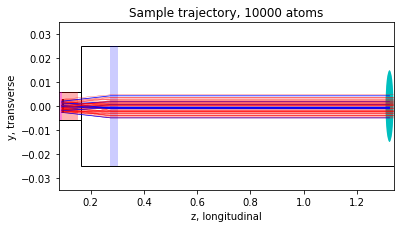

Flux:  0.001


In [ ]:
#Trajectory for debugging

# Create figure and axes
fig,ax = plt.subplots(1)

# Show vacuum system
rect = patches.Rectangle((oven_len_tot,-vac_diam/2),L_O_MOT+MOT_diam/2+0.05,vac_diam,linewidth=1,edgecolor='k',facecolor='none')
ax.add_patch(rect)
# Show end of oven
rect_ov = patches.Rectangle((0,-cruc_diam/2),oven_len_tot,cruc_diam,linewidth=1,edgecolor='k',facecolor='none')
ax.add_patch(rect_ov)
# Show EC
rect_ec = patches.Rectangle((0,-cruc_diam/2),cruc_len,cruc_diam,linewidth=1,edgecolor='none',facecolor=(1,0,0.7,0.5))
ax.add_patch(rect_ec)
# Show aperture/nozzle
rect_ap = patches.Rectangle((cruc_len,-array_diam/2),nozzle_len,array_diam,linewidth=1,edgecolor='none',facecolor='k')
ax.add_patch(rect_ap)
# Show HL
rect_hl = patches.Rectangle((cruc_len,-cruc_diam/2),hl_len,cruc_diam,linewidth=1,edgecolor='none',facecolor=(1,0,0,0.3))
ax.add_patch(rect_hl)
# Show TC
rect_TC = patches.Rectangle((L_O_TC,-vac_diam/2),TC_len,vac_diam,linewidth=1,edgecolor='none',facecolor=(0,0,1,0.2))
ax.add_patch(rect_TC)
# Show ZS
#rect_ZS = patches.Rectangle((L_O_ZS,-vac_diam/2),ZS_len,vac_diam,linewidth=1,edgecolor='none',facecolor=(1,0.54,0,0.2))
#ax.add_patch(rect_ZS)
# Show ZS beam
#rect_ZSb = patches.Rectangle((L_O_ZS,-ZS_beam_diam/2),ZS_len,ZS_beam_diam,linewidth=1,edgecolor='none',facecolor=(0,0,1,0.1))
#ax.add_patch(rect_ZSb)
# Show MOT cloud
cloud= patches.Circle((L_O_MOT,0),MOT_diam/2,linewidth=1,edgecolor='none',facecolor='c')
ax.add_patch(cloud)

#Do several sims to get a good pic
num_atoms=10000;
wincount=0;
for i in tqdm(range(num_atoms)):
  status,toss, xtraj, ytraj, ztraj = single_atom_simulation("Er",traj=1,dt=1e-7,nozzle_flag=1);
  wincount=wincount+status
  if status==1: plt.plot(ztraj,ytraj,'b',lw=0.75)
  else: plt.plot(ztraj,ytraj,'r',lw=0.25)

flux=wincount/num_atoms;

#plt.xlim((-0.01,L_O_MOT+MOT_diam/2+0.1))
plt.xlim((0.08,L_O_MOT+MOT_diam/2))
#plt.ylim((-vac_diam/2-0.1,vac_diam/2+0.1))
plt.ylim((-vac_diam/2-0.01,vac_diam/2+0.01))
plt.xlabel('z, longitudinal')
plt.ylabel('y, transverse')
plt.title('Sample trajectory, '+str(i+1)+' atoms')

ratio = 0.5
xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

plt.show();

print('Flux: ', flux)


Micronozzle throughput 5%, and this simulation's flux is 0.17%. So 0.0085% of atoms hitting the nozzle entrance are trappable on average. The nozzle array is ~20% porous, so 0.0017% of atoms hitting the EC front wall are good! So I just need a rate of incidence for that.

 https://en.wikipedia.org/wiki/Effusion says 

 $$
Rate/area = \frac{P}{\sqrt{2\pi m k_B T}}
 $$

 And the pressure is given by the Antoine equation

 $$
P = 10^{A-\frac{B}{C+T}}
 $$

 The constants of which are given by Frisch, giving ~1 Pa, and the nozzle array has diameter 6mm . This gives a rate of incidence ~1.5x10^17, so flux should be $ 2.5*10^{12} s^{-1} $ at the  MOT. 
 
 Frisch saw 10^14 /s /sr at the TC start without the collimation we hope to have. They estimate $ 10^8 s^{-1} $ at the MOT. 

To go forward recreating Frisch fig B.3(b) may be useful.

In [ ]:
flux_atoms_per_sec = flux*1470588235294117.8; #from below
print('flux: '+str(round(flux_atoms_per_sec/10**12,2))+'*10^12 atoms/sec')

flux: 1.4*10^12 atoms/sec


## Applications

In [ ]:
#4) Optical density of the atomic beam. tells us how significant absorption of the TC beams will be. That’s a big argument to have an aperture (block useless atoms)
#OD = number density * absorbtion xsec
#number density = flux/vz_avg/atom_beam_diam
#xsec from Foot

vavg=np.average(vz_mnf);
#phi=flux_atoms_per_sec;
phi=10**12;
lambda_o=lambda_er;
beam_diam=0.01; #NEED TO GET A VALUE HERE

OD=phi*lambda_o**2/(2*np.pi*vavg*beam_diam)/(1+(2*TC_detuning/linewidth_er)**2)

print("OD: "+str(round(OD,5)))


#NEEDS WORK

OD: 0.00444


In [ ]:
# flux as function of TC intensity, TC detuning

numspace=6;
TC_intens_arr=np.linspace(3*Isat_er,18*Isat_er,numspace);
TC_detun_arr=np.linspace(-0.5*linewidth_er,-5*linewidth_er,numspace);

flux_arr=np.zeros((numspace,numspace));

num_atoms=48000;

for j in tqdm(range(len(TC_intens_arr))):

  for k in range(len(TC_detun_arr)):

    TC_intensity=TC_intens_arr[j];
    TC_detuning=TC_detun_arr[k];

    #Do several sims to get a good pic
    wincount=0;
    for i in range(num_atoms):
      status,toss, xtraj, ytraj, ztraj = single_atom_simulation("Er",traj=1,dt=1e-7,nozzle_flag=1);
      wincount=wincount+status

    flux_arr[j,k]=wincount/num_atoms*1470588235294117.8;



#STARTING TO LOOK GOOD, DO MORE STATS AND WIDER ZOOM


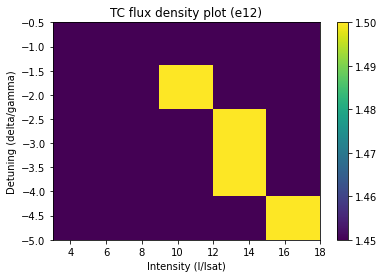

In [ ]:
plt.pcolormesh(TC_intens_arr/Isat_er,TC_detun_arr/linewidth_er,flux_arr/10**12,vmin=1.45,vmax=1.5)
plt.xlabel('Intensity (I/Isat)')
plt.ylabel('Detuning (delta/gamma)')
plt.title('TC flux density plot (e12)')
plt.colorbar()

plt.show();

In [ ]:
flux_arr

array([[1.28676471e+12, 1.19485294e+12, 1.43995098e+12, 1.22549020e+12,
        1.25612745e+12, 1.37867647e+12],
       [1.22549020e+12, 1.37867647e+12, 1.89950980e+12, 1.31740196e+12,
        1.43995098e+12, 1.71568627e+12],
       [1.31740196e+12, 1.31740196e+12, 1.22549020e+12, 1.53186275e+12,
        1.16421569e+12, 1.10294118e+12],
       [8.57843137e+11, 1.40931373e+12, 1.34803922e+12, 1.53186275e+12,
        1.10294118e+12, 1.47058824e+12],
       [1.19485294e+12, 1.04166667e+12, 1.37867647e+12, 1.16421569e+12,
        1.68504902e+12, 1.50122549e+12],
       [1.43995098e+12, 1.40931373e+12, 1.10294118e+12, 1.31740196e+12,
        1.40931373e+12, 1.28676471e+12]])


100%|██████████| 6/6 [3:53:04<00:00, 2330.83s/it]


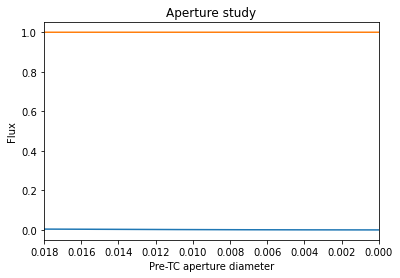

In [ ]:
#3) How large should the pre-TC aperture be? should see a sudden drop once you cut into the useful beam...

min=0;
max=1.5*cruc_diam;
num_steps=6;
pre_TC_ap_diam_arr=np.linspace(min,max,num_steps);

fluxes=[];
apcounts=[];
num_atoms=int(200*len(vz_mnf));

for i in tqdm(range(num_steps)):

  pre_TC_ap_diam=pre_TC_ap_diam_arr[i];

  wincount=0;
  apcount=0;
  for j in range(num_atoms):
    status,apflag, xtraj, ytraj, ztraj = single_atom_simulation("Er",traj=1,dt=1e-7,nozzle_flag=1);
    wincount=wincount+status
    apcount=apcount+apflag

  flux=wincount/num_atoms;
  fluxes.append(flux)
  apcounts.append(apcount/num_atoms)

# Create figure and axes
fig,ax = plt.subplots(1)
ax.set_xlim(max, min)

plt.plot(pre_TC_ap_diam_arr,fluxes,apcounts)
plt.xlabel("Pre-TC aperture diameter")
plt.ylabel("Flux")
plt.title("Aperture study")

plt.show();



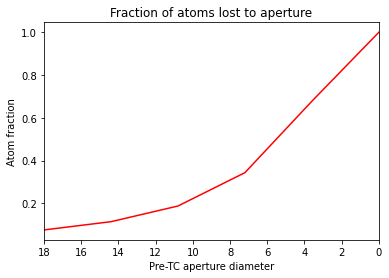

In [ ]:
norm_fluxes=np.array(fluxes)/np.max(fluxes)
norm_apcounts=np.array(apcounts)

crit_angles=np.arctan((pre_TC_ap_diam_arr/2)/(L_O_TC - cruc_len))*180/np.pi;
cauchy=1/(1+crit_angles**2)

fig,ax = plt.subplots(1)
ax.set_xlim(18,0)

plt.plot(pre_TC_ap_diam_arr*1000,norm_apcounts*1/(1+crit_angles**2),'r')
plt.xlabel("Pre-TC aperture diameter")
plt.ylabel("Atom fraction")
plt.title("Fraction of atoms lost to aperture")

plt.show();


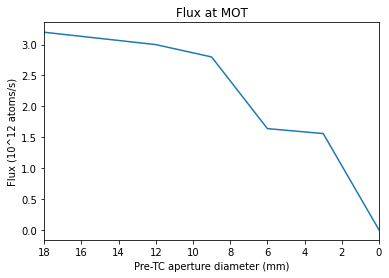

In [ ]:
#Data from previous runs
plot_diam=[40,31,22,13,12,6,3];
plot_flux=[16,14,8,7.5,7,4,4];

plot_diam=[18,12,9,6,3,0];
plot_flux=[8,7.5,7,4.1,3.9,0];

fig,ax = plt.subplots(1)
ax.set_xlim(40, 3)
ax.set_xlim(18, 0)

plt.plot(plot_diam,np.array(plot_flux)/2.5);
plt.xlabel("Pre-TC aperture diameter (mm)")
plt.ylabel("Flux (10^12 atoms/s)")
plt.title("Flux at MOT")

plt.show();


In [ ]:
#5) Beam shaping. Can we really shape the atomic beam usefully? 
#E.g. if you cut off the bottom half of the nozzles, how much of that shape is preserved by the time atoms reach the Li oven location?

#To do this, run a full simulation with with no aperture and output the trajectories.
#Plot an x-y scatter at the start for all atoms in a 2/3 window, then plot again at Li oven.
#Compare the two to see how well we can actually shape the beam.

num_atoms=300*len(vz_mnf);

x1=[]
y1=[]
x2=[]
y2=[]
#Do several sims to get a good pic

wincount=0;

for i in range(num_atoms):
  status, xtraj, ytraj, ztraj = single_atom_simulation("Er",traj=1,dt=1e-7,nozzle_flag=1);
  wincount=wincount+status

  #BEAM SHAPING
  if ((abs(xtraj[0])>np.tan(np.pi/3)*abs(ytraj[0])) or (ytraj[0]>0)):
    x1.append(xtraj[0])
    y1.append(ytraj[0])
    endflag=0
    for j in range(len(ztraj)):
      if (ztraj[j] > (L_O_TC+TC_len+(0.066/2-TC_len/2))) and (endflag==0):
        endflag=1;
        spot=j
        x2.append(xtraj[spot])
        y2.append(ytraj[spot])
      else: pass

flux=wincount/num_atoms*1470588235294117.8;

x1u=[]
y1u=[]
x2u=[]
y2u=[]
#Do several sims to get a good pic

wincountu=0;

for i in range(num_atoms):
  status, xtraj, ytraj, ztraj = single_atom_simulation("Er",traj=1,dt=1e-7,nozzle_flag=1);
  wincountu=wincountu+status

  #NO BEAM SHAPING
  if 0==0:
    x1u.append(xtraj[0])
    y1u.append(ytraj[0])
    endflag=0
    for j in range(len(ztraj)):
      if (ztraj[j] > (L_O_TC+TC_len+(0.066/2-TC_len/2))) and (endflag==0):
        endflag=1;
        spot=j
        x2u.append(xtraj[spot])
        y2u.append(ytraj[spot])
      else: pass

fluxu=wincountu/num_atoms*1470588235294117.8;


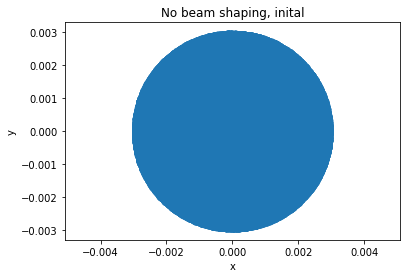

In [ ]:
fig,ax = plt.subplots(1)
ax.axis('equal')

plt.plot(x1u,y1u,'.')
lim_shape=1.1*array_diam/2;
plt.ylim([-lim_shape,lim_shape])
plt.xlim([-lim_shape,lim_shape]);
plt.xlabel('x')
plt.ylabel('y')
plt.title('No beam shaping, inital')
plt.show();

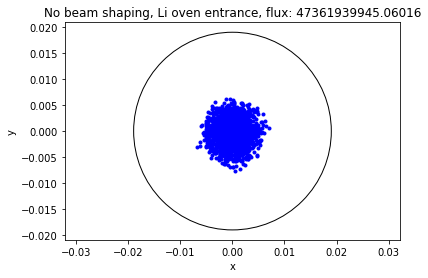

In [ ]:
#Analyze unshaped trajectories

unshaped_count=0;
for i in range(len(x2u)):
  if ((abs(x2u[i])>np.tan(np.pi/3)*abs(y2u[i])) or (y2u[i]>0)):
    unshaped_count=unshaped_count+1;

unshaped_frac=unshaped_count/len(x2u);
final_fluxu=fluxu*unshaped_frac;

# Create figure and axes (initial)
fig,ax = plt.subplots(1)
ax.axis('equal')
  
plt.plot(x2u,y2u,c='b',marker='.',ls='')
plt.xlabel('x')
plt.ylabel('y')
plt.title('No beam shaping, Li oven entrance, flux: '+str(final_fluxu))

Li_oven_patch= patches.Circle((0,0),0.019,linewidth=1,edgecolor='k',facecolor='none')
ax.add_patch(Li_oven_patch)

plt.show();

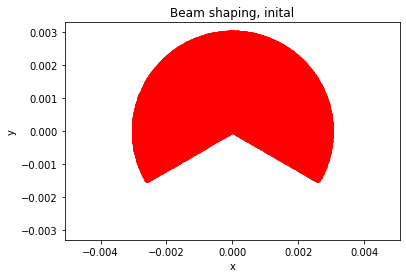

In [ ]:
fig,ax = plt.subplots(1)
ax.axis('equal')

plt.plot(x1,y1,'.',c='r');
lim_shape=1.1*array_diam/2;
plt.ylim([-lim_shape,lim_shape])
plt.xlim([-lim_shape,lim_shape]);
plt.xlabel('x')
plt.ylabel('y')
plt.title('Beam shaping, inital')
plt.show();

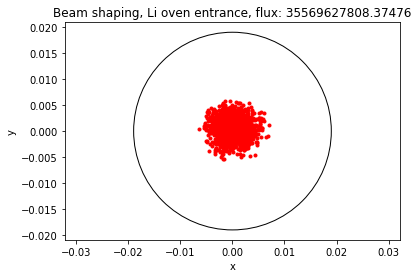

In [ ]:
#Analyze shaped trajectories

shaped_count=0;
for i in range(len(x2)):
  if ((abs(x2[i])>np.tan(np.pi/3)*abs(y2[i])) or (y2[i]>0)):
    shaped_count=shaped_count+1;

shaped_frac=shaped_count/len(x2);
final_flux=2/3*flux*shaped_frac; #Found in previous run


# Create figure and axes (final)
fig,ax = plt.subplots(1)
ax.axis('equal')

plt.plot(x2,y2,c='r',marker='.',ls='')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Beam shaping, Li oven entrance, flux: '+str(final_flux))

Li_oven_patch= patches.Circle((0,0),0.019,linewidth=1,edgecolor='k',facecolor='none')
ax.add_patch(Li_oven_patch)

plt.show();

In [ ]:
#Data generated from previous runs not shown here

with_li_oven_flux=0.00006*1470588235294117.8;

pre_li_flux=with_li_oven_flux*(1.15625); #This includes losses due to increased length
pre_li_flux=with_li_oven_flux*(1); #This doesn't include losses due to increased length
pre_li_flux_shaped=2/3*pre_li_flux;

lost_atoms_unshaped=(pre_li_flux-final_fluxu);
lost_atoms_shaped=(pre_li_flux_shaped-final_flux);


In [ ]:
print("Flux at MOT (10^10 atoms/s):")
print("")
print("No Li oven or beamshaping: "+str(round(pre_li_flux/10**10,2)))
print("With Li oven, no beamshaping: "+str(round(final_fluxu/10**10,2)))
print("No beamshaping lost atoms: "+str(round(lost_atoms_unshaped/10**10,2)))
print("")
print("No Li oven, with beamshaping: "+str(round(pre_li_flux_shaped/10**10,2)))
print("With Li oven and beamshaping: "+str(round(final_flux/10**10,2)))
print("Beamshaping lost atoms: "+str(round(lost_atoms_shaped/10**10,2)))
print("")
print("Beamshaping flux reduction: "+str(round((final_fluxu-final_flux)/final_fluxu*100,2))+"%")
print("Beamshaping loss reduction: "+str(round((lost_atoms_unshaped-lost_atoms_shaped)/lost_atoms_unshaped*100,2))+"%")

Flux at MOT (10^10 atoms/s):

No Li oven or beamshaping: 8.82
With Li oven, no beamshaping: 4.74
No beamshaping lost atoms: 4.09

No Li oven, with beamshaping: 5.88
With Li oven and beamshaping: 3.56
Beamshaping lost atoms: 2.33

Beamshaping flux reduction: 24.9%
Beamshaping loss reduction: 43.11%


In [ ]:
print(1-shaped_frac)
print(1-unshaped_frac)

0.22622478386167144
0.37037037037037035


In [ ]:
# Effect of TC beam diameter

TC_power = 0.04; #40mW in Frisch, 80mW in Phelps, 100mW in Vilas
TC_detuning=-0.75*linewidth_er; #[Hz] from optimization above
TC_long_axis = 0.05; #going up to 100 mm diameter
TC_short_axis = 0.0015; #1.5mm short axis

num_steps=10;
TC_long_axis_arr=np.linspace(TC_short_axis,TC_long_axis,num_steps);

fluxes=[];
num_atoms=150000;

for i in range(num_steps):

  #################################
  TC_len=2*TC_long_axis_arr[i]; #length of TC [m] from beam diameter

  L_O_TC=oven_len_tot+0.06; #start right after port aligner
  L_O_ZS=L_O_TC+TC_len+0.125+0.4; #length from back of crucible to ZS [m]
  L_O_MOT=L_O_ZS+ZS_len+0.089; #length from back of crucible to MOT [m] (centered in Kimball physics chamber)
  TC_intensity=TC_power/(np.pi*TC_len*TC_short_axis); #[W/m^2]
  #################################

  wincount=0;
  for j in tqdm(range(num_atoms)):
    status,apflag, xtraj, ytraj, ztraj = single_atom_simulation("Er",traj=1,dt=1e-7,nozzle_flag=1); #trajflag 0 faster?
    wincount=wincount+status

  flux=wincount/num_atoms;
  fluxes.append(flux)



100%|██████████| 150000/150000 [32:58<00:00, 75.81it/s]


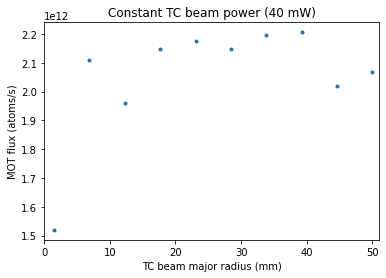

In [ ]:
# Create figure and axes
fig,ax = plt.subplots(1)
ax.set_xlim(0, 51)



plt.plot(TC_long_axis_arr*1000,np.array(fluxes)*1470588235294117.8,'.',label='simulated')
plt.xlabel("TC beam major radius (mm)")
plt.ylabel("MOT flux (atoms/s)")
plt.title("Constant TC beam power (40 mW)")
#plt.legend()

plt.show();

In [ ]:
TC_power = 0.08; #40mW in Frisch, 80mW in Phelps, 100mW in Vilas
TC_detuning=-0.75*linewidth_er; #[Hz] from optimization above
TC_long_axis = 0.05; #going up to 100 mm diameter
TC_short_axis = 0.0015; #1.5mm short axis

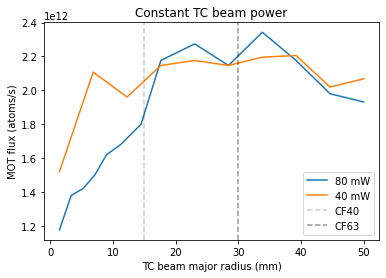

In [ ]:
#Final Plots

big_rad=np.array([1.5,3.38,5.25,7.125,9,11.25,14.5,17.67,23.06,28.44,33.83,39.22,44.61,50]);
flux_res=np.array([1.1765,1.38,1.42,1.5,1.62,1.68,1.8,2.1767,2.2745,2.1471,2.3431,2.1765,1.9804,1.9314])*10**12;

plt.plot(big_rad,flux_res,label="80 mW")
plt.plot(TC_long_axis_arr*1000,np.array(fluxes)*1470588235294117.8,label='40 mW')

plt.axvline(x=15,ls='dashed',c='k',alpha=0.2,label='CF40')
plt.axvline(x=30,ls='dashed',c='k',alpha=0.4,label='CF63')

plt.xlabel("TC beam major radius (mm)")
plt.ylabel("MOT flux (atoms/s)")
plt.title("Constant TC beam power")
plt.legend()

plt.show();